In [1]:
import pandas as pd 
import numpy as np
from lightgbm import LGBMClassifier,plot_importance
from sklearn import model_selection
from sklearn.metrics import roc_auc_score,log_loss
import matplotlib.pyplot as plt
import optuna
import joblib
from sklearn.preprocessing import RobustScaler,PolynomialFeatures

In [3]:
train_df = pd.read_csv('../input/tabular-playground-series-sep-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-sep-2021/test.csv')

In [4]:
features = train_df.drop(columns=['claim','id']).columns
features = list(features)

In [5]:
train_df['n_missing'] = train_df[features].isna().sum(axis=1)
test_df['n_missing'] = test_df[features].isna().sum(axis=1)

In [6]:
train_df['std'] = train_df[features].std(axis=1)
test_df['std'] = test_df[features].std(axis=1)

In [7]:
train_df['sum'] = train_df[features].sum(axis=1)
test_df['sum'] = test_df[features].sum(axis=1)

In [8]:
train_df[features] = train_df[features].fillna(train_df[features].mean())
test_df[features] = test_df[features].fillna(test_df[features].mean())

In [9]:
features+= ['n_missing', 'std']

In [10]:
scaler = RobustScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

In [11]:
def make_folds(df):
    '''
    Function create Stratified K folds on the dataset
    Parameters
    ----------
    df : dataframe
    Returns
    -------
    dataframe
    '''
    
    df['kfold'] = -1
    df = df.sample(frac=1).reset_index(drop=True)
    y = df.claim.values
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
        df.loc[v_,'kfold'] = f
        
    return df

In [19]:
train_df = make_folds(train_df)

In [20]:
N_SPLITS = 5
N_ESTIMATORS = 20000
EARLY_STOPPING_ROUNDS = 200
VERBOSE = 1000
SEED = 2021

In [21]:
lgb_params = {
    'objective': 'binary',
    'n_estimators': N_ESTIMATORS,
    'random_state': SEED,
    'learning_rate': 5e-3,
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.4,
    'reg_alpha': 10.0,
    'reg_lambda': 1e-1,
    'min_child_weight': 256,
    'min_child_samples': 20,
}

In [22]:
models = {
    'lgbm':LGBMClassifier(**lgb_params)
}

In [23]:
def run_folds(df,fold,model):
    '''
    Funtcion to train and predict on the models on the given fold
    Input : Dataframe,Integer,Model
    Output: NULL
    '''
    df_train = df[df.kfold!=fold].reset_index(drop=True)
    df_valid = df[df.kfold==fold].reset_index(drop=True)
    
    x_train = df_train.drop(columns=['claim','kfold','id'],axis=1).values
    y_train = df_train.claim.values
    
    x_valid = df_valid.drop(columns=['claim','kfold','id'],axis=1).values
    y_valid = df_valid.claim.values
    
    
    clf = models[model]
    
    clf.fit(x_train,y_train,eval_set=[(x_valid, y_valid)],
        eval_metric='auc',
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE)
    
    print(f'Fold{fold}')
    print('*'*50)
    
    joblib.dump(clf,f'new_dt_{fold}_{model}.bin')
    
    return

In [24]:
for i in range(5):
    run_folds(train_df,i,'lgbm')

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.810758	valid_0's binary_logloss: 0.514479
[2000]	valid_0's auc: 0.813655	valid_0's binary_logloss: 0.507439
[3000]	valid_0's auc: 0.814738	valid_0's binary_logloss: 0.506452
[4000]	valid_0's auc: 0.815304	valid_0's binary_logloss: 0.506025
[5000]	valid_0's auc: 0.815652	valid_0's binary_logloss: 0.50578
[6000]	valid_0's auc: 0.815899	valid_0's binary_logloss: 0.505617
[7000]	valid_0's auc: 0.816086	valid_0's binary_logloss: 0.505501
[8000]	valid_0's auc: 0.816237	valid_0's binary_logloss: 0.505415
[9000]	valid_0's auc: 0.816371	valid_0's binary_logloss: 0.505337
[10000]	valid_0's auc: 0.816436	valid_0's binary_logloss: 0.5053
Early stopping, best iteration is:
[9899]	valid_0's auc: 0.816444	valid_0's binary_logloss: 0.505294
Fold0
**************************************************
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.810642	valid_0's binary_logloss: 0.5

In [25]:
test = test_df.drop(columns=['id'])
md = joblib.load('./new_dt_1_lgbm.bin')
prediction = md.predict_proba(test)[:,1]
submission = pd.DataFrame({'id': test_df['id'],'claim': prediction})
submission.to_csv('submission_6.csv',index=False)

In [26]:
submission.head()

,id,claim
0,957919,0.582832
1,957920,0.119646
2,957921,0.630650
3,957922,0.133811
4,957923,0.141323


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

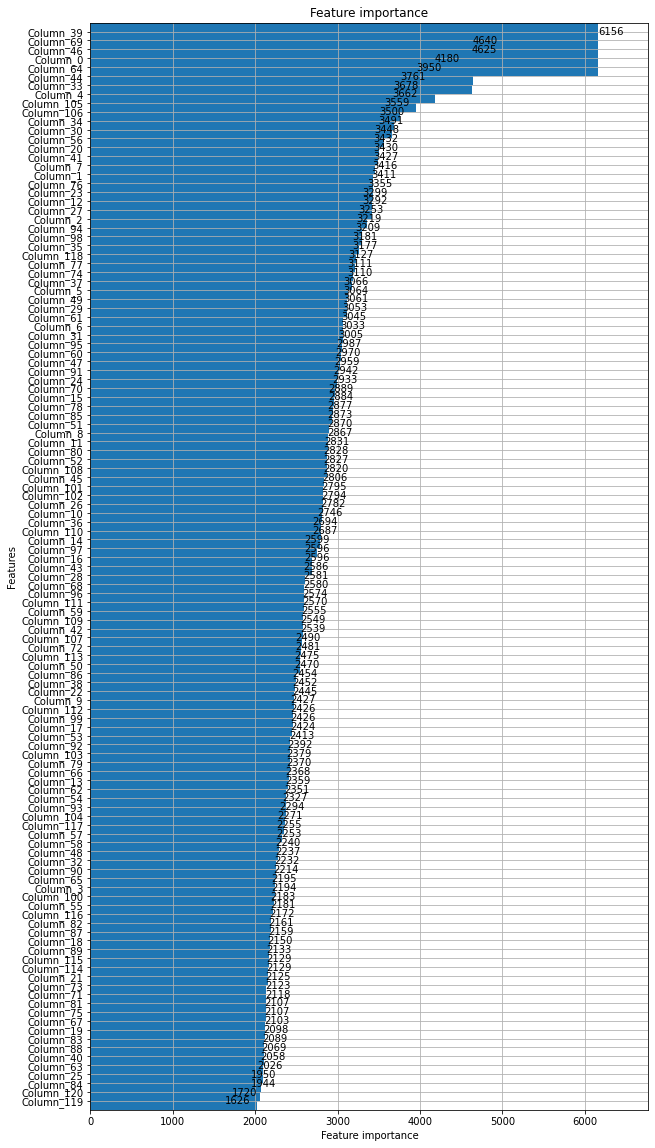

In [27]:
plot_importance(md,height=10,figsize=(10,20))

In [31]:
important_features = []
for i,score in enumerate(md.feature_importances_):
    if(score>3500):
        important_features.append(f'f{i+1}')
    else:
        continue

In [12]:
important_features = ['f1', 'f5', 'f34', 'f40', 'f45', 'f47', 'f65', 'f70', 'f106']

In [13]:
pf = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
pf.fit(train_df[important_features])
poly_feats = pf.transform(train_df[important_features])
poly_feats_test = pf.transform(test_df[important_features])

In [14]:
num_feats = poly_feats.shape[1]
poly_feats_df = pd.DataFrame(poly_feats,columns=[f'new_f{i}'for i in range(1,num_feats+1)])
poly_feats_test_df = pd.DataFrame(poly_feats_test,columns=[f'new_f{i}'for i in range(1,num_feats+1)])

In [15]:
train_df = pd.concat([train_df,poly_feats_df],axis=1)
test_df = pd.concat([test_df,poly_feats_test_df],axis=1)

In [ ]:
f1', 'f5', 'f34', 'f40', 'f45', 'f47', 'f65', 'f70', 'f106'